<a href="https://colab.research.google.com/github/sdrl77/sdrl77/blob/main/Memristor_ANN_mnist_Temp_TaOx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
import keras
from keras.models import Sequential #importing model from keras
from keras.layers import Dense
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers.core import Dense,Activation,Dropout

In [ ]:
# 自定义SGD优化器
class MySGD(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, k_LTP=1, k_LTD=1, name="MySGD", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super(MySGD, self).__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        # 添加LTP/LTD作为优化器的输入值
        self.k_LTP = k_LTP
        self.k_LTD = k_LTD
        self._is_first = True

    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "pv") #previous variable i.e. weight or bias
        for var in var_list:
            self.add_slot(var, "pg") #previous gradient


    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        new_var_LTD = var - grad * lr_t * self.k_LTD
        new_var_LTP = var - grad * lr_t * self.k_LTP
        pv_var = self.get_slot(var, "pv")
        pg_var = self.get_slot(var, "pg")

        #在weight update过程中考虑LTP/LTD的影响
        if self._is_first:
            self._is_first = False
            new_var = new_var_LTD
        else:
            cond = pg_var > 0
            print(cond)
            new_var = tf.where(cond, new_var_LTD, new_var_LTP)


        pv_var.assign(var)
        pg_var.assign(grad)
        var.assign(new_var)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            #"learning_rate": self.learning_rate,
            "k_LTP": self.k_LTP,
            "k_LTD": self.k_LTD
        }

In [ ]:
def model_init(LTP, LTD):
  sgd = MySGD(learning_rate=0.02, k_LTP = LTP, k_LTD = LTD)
  #model initialization
  model = Sequential()

  # adding the first layer to the model (hidden)
  model.add(Dense(200, input_dim=x_train.shape[1], kernel_initializer='uniform', activation='relu'))
  # adding the output layer
  model.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
  # compile the model for model
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
#Reshaping the data 2D
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)
#one- hot encoding the target variable
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
#Scaling the value
minmax = MinMaxScaler()
x_train=minmax.fit_transform(x_train)
x_test=minmax.transform(x_test)
#Split the tarin data further into trainig set and validationd set
x_train, x_val, y_train, y_val=train_test_split(x_train, y_train, test_size = 0.8, random_state = 1)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

11501568/11490434 [==============================] - 0s 0us/step
(12000, 784) (48000, 784) (12000, 10) (48000, 10)


In [ ]:
model_25 = model_init(1, 1)
model_25_fit = model_25.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_val, y_val), verbose=1)

Epoch 1/50
Tensor("Greater:0", shape=(200,), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("Greater:0", shape=(200, 10), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("Greater:0", shape=(10,), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
2400/2400 [==============================] - 30s 12ms/step - loss: 0.6122 - accuracy: 0.8317 - val_loss: 0.3396 - val_accuracy: 0.9035
Epoch 2/50
2400/2400 [==============================] - 26s 11ms/step - loss: 0.2861 - accuracy: 0.9173 - val_loss: 0.2997 - val_accuracy: 0.9089
Epoch 3/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.2185 - accuracy: 0.9353 - val_loss: 0.2353 - val_accuracy: 0.9309
Epoch 4/50
2400/2400 [==============================] - 27s 11ms/step - loss: 0.1761 - accuracy: 0.9483 - val_loss: 0.2140 - val_accuracy: 0.9377
Epoch 5/50
2400/2400 [==============================] - 17s 7ms/step - loss: 0.1439 - accuracy: 0.9583 - val_loss: 0.1

In [ ]:
model_105 = model_init(0.2, 0.2)
model_105_fit = model_105.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_val, y_val), verbose=1)

Epoch 1/50
Tensor("Greater:0", shape=(200,), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("Greater:0", shape=(200, 10), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("Greater:0", shape=(10,), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
2400/2400 [==============================] - 17s 7ms/step - loss: 1.3179 - accuracy: 0.7005 - val_loss: 0.6435 - val_accuracy: 0.8421
Epoch 2/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.5057 - accuracy: 0.8718 - val_loss: 0.4381 - val_accuracy: 0.8824
Epoch 3/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.3896 - accuracy: 0.8936 - val_loss: 0.3793 - val_accuracy: 0.8925
Epoch 4/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.3428 - accuracy: 0.9045 - val_loss: 0.3550 - val_accuracy: 0.8986
Epoch 5/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.3153 - accuracy: 0.9112 - val_loss: 0.3306

In [ ]:
model_85 = model_init(0.5, 0.5)
model_85_fit = model_85.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_val, y_val), verbose=1)

Epoch 1/50
Tensor("Greater:0", shape=(200,), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("Greater:0", shape=(200, 10), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("Greater:0", shape=(10,), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
2400/2400 [==============================] - 17s 7ms/step - loss: 0.8359 - accuracy: 0.7758 - val_loss: 0.4174 - val_accuracy: 0.8810
Epoch 2/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.3514 - accuracy: 0.8991 - val_loss: 0.3417 - val_accuracy: 0.9017
Epoch 3/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.2939 - accuracy: 0.9143 - val_loss: 0.3026 - val_accuracy: 0.9139
Epoch 4/50
2400/2400 [==============================] - 26s 11ms/step - loss: 0.2555 - accuracy: 0.9273 - val_loss: 0.2781 - val_accuracy: 0.9192
Epoch 5/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.2244 - accuracy: 0.9346 - val_loss: 0.265

In [ ]:
model_m10 = model_init(1.5, 1.5)
model_m10_fit = model_m10.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_val, y_val), verbose=1)

Epoch 1/50
Tensor("Greater:0", shape=(200,), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("Greater:0", shape=(200, 10), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("Greater:0", shape=(10,), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
2400/2400 [==============================] - 17s 7ms/step - loss: 0.5330 - accuracy: 0.8483 - val_loss: 0.3536 - val_accuracy: 0.8904
Epoch 2/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.2581 - accuracy: 0.9252 - val_loss: 0.2387 - val_accuracy: 0.9297
Epoch 3/50
2400/2400 [==============================] - 26s 11ms/step - loss: 0.1815 - accuracy: 0.9447 - val_loss: 0.2148 - val_accuracy: 0.9357
Epoch 4/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.1387 - accuracy: 0.9585 - val_loss: 0.1855 - val_accuracy: 0.9452
Epoch 5/50
2400/2400 [==============================] - 26s 11ms/step - loss: 0.1081 - accuracy: 0.9700 - val_loss: 0.16

In [ ]:
model_m40 = model_init(2, 2)
model_m40_fit = model_m40.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_val, y_val), verbose=1)

Epoch 1/50
Tensor("Greater:0", shape=(200,), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("Greater:0", shape=(200, 10), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
Tensor("Greater:0", shape=(10,), dtype=bool, device=/job:localhost/replica:0/task:0/device:CPU:0)
2400/2400 [==============================] - 17s 7ms/step - loss: 0.4900 - accuracy: 0.8570 - val_loss: 0.2841 - val_accuracy: 0.9166
Epoch 2/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.2225 - accuracy: 0.9341 - val_loss: 0.2364 - val_accuracy: 0.9295
Epoch 3/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.1517 - accuracy: 0.9542 - val_loss: 0.2037 - val_accuracy: 0.9377
Epoch 4/50
2400/2400 [==============================] - 16s 7ms/step - loss: 0.1097 - accuracy: 0.9690 - val_loss: 0.2014 - val_accuracy: 0.9387
Epoch 5/50
2400/2400 [==============================] - 26s 11ms/step - loss: 0.0805 - accuracy: 0.9778 - val_loss: 0.149

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


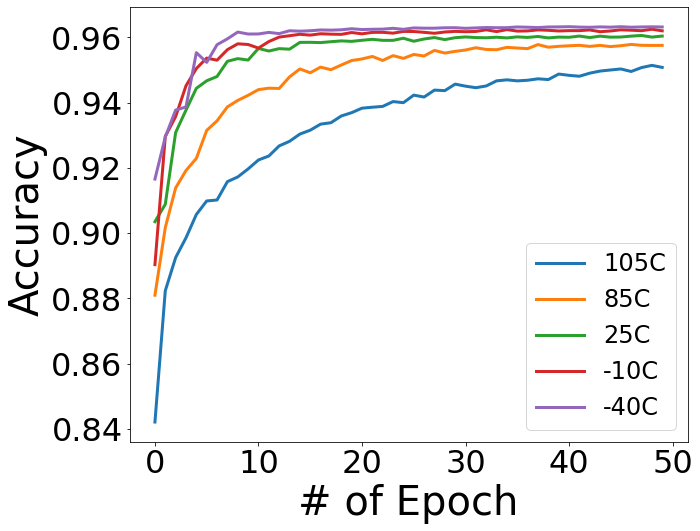

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'sans:italic'
mpl.rcParams['mathtext.default'] = 'it'

plt.figure(figsize=(10,8))
plt.subplot(1,1,1)
plt.plot(model_105_fit.history['val_accuracy'], label='105C', linewidth=3)
plt.plot(model_85_fit.history['val_accuracy'], label='85C', linewidth=3)
plt.plot(model_25_fit.history['val_accuracy'], label='25C', linewidth=3)
plt.plot(model_m10_fit.history['val_accuracy'], label='-10C', linewidth=3)
plt.plot(model_m40_fit.history['val_accuracy'], label='-40C', linewidth=3)
plt.xlabel('# of Epoch', fontdict={'family':'Times New Roman', 'size':40})
plt.ylabel('Accuracy', fontdict={'family':'Times New Roman', 'size': 40})
plt.yticks(fontproperties = 'Times New Roman', size = 32)
plt.xticks(fontproperties = 'Times New Roman', size = 32)
plt.legend(loc='best', prop={'family':'Times New Roman', 'size':24})
plt.show()

In [ ]:
import sys
PATH = '/content/drive/MyDrive/mnist_keras'
sys.path.append(PATH)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.savetxt(PATH + "/temp_train_accu/accu_105.txt", model_105_fit.history['val_accuracy'], fmt = '%f',delimiter = ', ')
np.savetxt(PATH + "/temp_train_accu/accu_85.txt", model_85_fit.history['val_accuracy'], fmt = '%f',delimiter = ', ')
np.savetxt(PATH + "/temp_train_accu/accu_25.txt", model_25_fit.history['val_accuracy'], fmt = '%f',delimiter = ', ')
np.savetxt(PATH + "/temp_train_accu/accu_-10.txt", model_m10_fit.history['val_accuracy'], fmt = '%f',delimiter = ', ')
np.savetxt(PATH + "/temp_train_accu/accu_-40.txt", model_m40_fit.history['val_accuracy'], fmt = '%f',delimiter = ', ')